In [4]:
import json
import bson

## Data 불러오기

In [5]:
file_path = './outputdump.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.loads(file.read())
    print(type(data))
    print(data)


<class 'list'>
[{'_id': {'$oid': '640803455de52bf849b8d9ba'}, '_idx': 1, 'cat1': '정치', 'cat2': '대통령실', 'title': '[뉴스포커스] 윤대통령, 4월말 미국 국빈 방문…한미 밀착 가속화', 'description': '윤석열 대통령이 다음 달 말 미국에서 바이든 대통령과 정상회담을 갖습니다. 이번 방미는 국빈방문으로 대통령실은 역사적 전기가 될 …', 'press': '연합뉴스TV', 'link': 'https://n.news.naver.com/mnews/article/422/0000587594?sid=100', 'publish_date': '2023-03-08 10:48:03', 'full_text': '<출연 : 김재천 서강대학교 국제대학원 교수>윤석열 대통령이 다음 달 말 미국에서 바이든 대통령과 정상회담을 갖습니다. 이번 방미는 국빈방문으로 대통령실은 역사적 전기가 될 것이라 밝혔는데요. 이달 중엔 한일정상회담을 위해 일본 방문도 유력하게 검토되고 있어 한미일 삼각 협력이 가속화될 것으로 보입니다. 관련 내용들, 김재천 서강대학교 국제대학원 교수와 함께 이야기 나눠보겠습니다. 어서 오세요. <질문 1> 먼저, 어젯밤 늦게 워싱턴포스트에서 가장 먼저 보도를 했는데요. 백악관은 윤대통령의 미국 국빈방문 일정이 4월 26일로 예정됐으며, 국빈 만찬이 포함된다고 발표했습니다. 윤 대통령이 취임 이후에 한미정상회담에 나서는 것이 벌써 세 번째인데요. 이번엔 국빈 방문입니다. 이번 한미정상회담의 의미는 뭐라고 보시나요? <질문 1-1> 국빈 방문은 2011년 이명박 전 대통령의 국빈 방문 이후 12년 만이고, 바이든 정부 출범 후 국빈 형식으로 미국을 방문했던 정상도 윤 대통령이 두 번째가 된다고 하는데, 국빈 방문의 의미도 좀 짚어주시죠. <질문 2> 아직 확정이 되진 않았지만, 미 의회에서 연설도 관측되고 있는데요. 보통 외국 정상이 국빈 방문을 하면 미 상·하원 합동회의 연설을

## 데이터 전처리 및 Token화
- Stemming 및 외래어 부분 참조 [link](https://colab.research.google.com/drive/1FfhWsP9izQcuVl06P30r5cCxELA1ciVE?usp=sharing#scrollTo=mQtv-RQDAGtF)
- 불용어 처리 코드 참조 [link](https://velog.io/@jochedda/NLP-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%A0%84%EC%B2%98%EB%A6%AC)
- 모델별 결과 참조 [link](https://dacon.io/codeshare/1808)

In [6]:
from konlpy.tag import Kkma, Komoran, Okt
# 형태소 분석 library import
okt = Okt()
kkm = Kkma()
kom = Komoran()
# komoran은 빈줄이 있으면 에러가 남
# komoran.morphs("\n".join([s for s in c[:40].split("\n") if s]))

In [7]:
# 중복 반복되는 단어 정규화
# from soynlp.normalizer import *
# repeat_normalize('와하하하하하하하하하핫', num_repeats=2)

'와하하핫'

In [8]:
# mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim import corpora # 단어 빈도수 계산 패키지
from collections import Counter # 단어 등장 횟수 카운트
import pandas as pd

In [9]:
df_raw = pd.DataFrame(data)
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           15 non-null     object
 1   _idx          15 non-null     int64 
 2   cat1          15 non-null     object
 3   cat2          15 non-null     object
 4   title         15 non-null     object
 5   description   15 non-null     object
 6   press         15 non-null     object
 7   link          15 non-null     object
 8   publish_date  15 non-null     object
 9   full_text     15 non-null     object
 10  img_src       15 non-null     object
dtypes: int64(1), object(10)
memory usage: 1.4+ KB
None


In [10]:
df_raw.isnull().sum()

_id             0
_idx            0
cat1            0
cat2            0
title           0
description     0
press           0
link            0
publish_date    0
full_text       0
img_src         0
dtype: int64

In [11]:
# 결측치 제거 (형태소 분석 진행시 null값이 존재하면 오류 발생)
df = df_raw.dropna(axis = 0)
df.isnull().sum()

_id             0
_idx            0
cat1            0
cat2            0
title           0
description     0
press           0
link            0
publish_date    0
full_text       0
img_src         0
dtype: int64

In [12]:
# 분석에서 제외할 데이터 제거
df.reset_index(drop = True, inplace=True) # 인덱스 초기화

In [13]:
# 토큰화 이전 불필요한 글자들 전처리
# punctuation 삭제
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } 
def clean(text):
    for p in punct_mapping:
        text = text.replace(p, punct_mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()


import re

# 불필요한 부분 삭제(이메일, url등)
def clean_str(text):
    pattern = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub(r'\n', '.', string=text)
    return text 


동사를 원형으로 복원하도록 하겠습니다. 규칙은 다음과 같습니다.

1. NNG|NNP|NNB + XSV|XSA --> NNG|NNP|NNB + XSV|XSA + 다
2. NNG|NNP|NNB + XSA + VX --> NNG|NNP + XSA + 다
3. VV --> VV + 다
4. VX --> VX + 다

In [14]:
# 동사 원형 복원
p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                if tag != 'VX':
                    modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append((ori_sent))
    return corpus

In [15]:
# 불용어 제거
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = list(words.split('\n'))

def token(txt):
    txt = clean(txt)
    txt = clean_str(txt)
    word_tokens = kom.pos(txt, join="/")
    stemming_result = stemming_text(word_tokens)
    result = [word for word in stemming_result if not word[0] in stop_words]
    return result
df["token"] = df["full_text"].apply(token)

In [16]:
# for i in df["token"]:
#     print(' '.join(i[:20]))
print(df.token)

0     [윤석열/NNP, 대통령/NNG, 다음/NNG, 달/NNG, 말/NNG, 미국/NN...
1     [기사/NNG, 내용/NNG, 요약/NNG, 美/SH, 방미/NNP, 고대/NNP,...
2     [국무회의/NNP, 서/JKB, 대선/NNG, 징용/NNP, 직접/MAG, 언급/N...
3     [부정/NNG, 평가/NNG, 는/JX, 53/SN, 8/SN, 국민/NNG, 힘/...
4     [기사/NNG, 내용/NNG, 요약/NNG, 피해자/NNG, 존중/NNG, 尹/SH...
5     [한/MM, 미/NNP, 동맹/NNP, 70/SN, 주년/NNB, 동맹/NNP, 틀...
6     [尹/SH, 대통령/NNP, 4월/NNP, 말/NNG, 바이든/NNP, 대통령/NN...
7     [美/SH, 전략/NNP, 전개/NNG, 연합/NNG, 훈련/NNG, 美/SH, 방...
8     [기사/NNG, 내용/NNG, 요약佛마크롱/NA, 국빈/NNG, 방문/NNP, 교육...
9     [尹/SH, 대통령/NNP, 4월/NNP, 미국/NNP, 국빈/NNG, 방문/NNP...
10    [부정/NNP, 평가/NNP, 53/SN, 8/SN, 지난해/NNG, 7월/NNP,...
11    [윤석열/NNP, 대통령/NNG, 조 바이든/NNP, 미국/NNP, 대통령/NNG,...
12    [윤석열/NNP, 대통령/NNG, 7/SN, 서울/NNP, 용산/NNP, 대통령/N...
13    [윤/NNP, 대통령/NNG, 내달/NNG, 26/SN, 국빈/NNG, 방문/NNP...
14    [방미/NNP, 앞두다/VV, 고/EC, 세일즈/NNG, 외교/NNP, 강조/NNG...
Name: token, dtype: object


In [17]:
# 띄어쓰기 적용 코드, 다만 이부분은 기사 자료이기 때문에 우선 넘기기
# from pykospacing import Spacing
# spacing = Spacing()
# kospacing_sent = spacing(new_sent) 

# print(sent)
# print(kospacing_sent)

In [18]:
# 기존 토크나이저 들의 문제점인 신조어 인식이 어려운 점을 해소하는 soynlp
# from soynlp import DoublespaceLineCorpus
# from soynlp.word import WordExtractor
# 다만 이 경우, 학습을 거쳐 토큰화 시키는것이기 때문에, 일단 생략하도록 하겠다 방식은 노션을 참고하자

## Word2Vec 구현
- 기존의 원핫 인코딩 보다 차원적인 측면에서 자원을 덜 소모하는 장점
- CBOW 와 Skip-gram 이 존재 [link](https://wooono.tistory.com/244)
  - 둘의 차이는 둘의 input 과 output 방식이 반대라는 점
  - CBOW (Continuous Bag of Words)
    - 주변 단어를 활용하여 주어진 단어를 예측
  - Skip-gram
    - 해당 단어를 보고 주변 단어를 예측
- 딥러닝을 활용한 자연어 처리 입문 참고 [link](https://wikidocs.net/50739)
- 

In [19]:
from gensim.models import Word2Vec # word2vec 모델 import

In [20]:
# model train sentences = data
model = Word2Vec(sentences=df.token, vector_size = 100, window = 8, min_count = 3, workers = 4, sg = 0) # sg = 0 이면 cbow, 1이면 skip-gram
model.wv.vectors.shape

(510, 100)

In [21]:
# 결과 확인용
model.wv.most_similar("윤석열/NNP")

[('다/EC', 0.9993928074836731),
 ('았/EP', 0.9993926286697388),
 ('미/NNP', 0.9993674755096436),
 ('있다/VV', 0.9993640184402466),
 ('ㄹ/ETM', 0.9993578195571899),
 ('는/ETM', 0.9993575811386108),
 ('억제/NNG', 0.9993318915367126),
 ('적/XSN', 0.9993290901184082),
 ('고/EC', 0.9993247985839844),
 ('은/JX', 0.9993239045143127)]

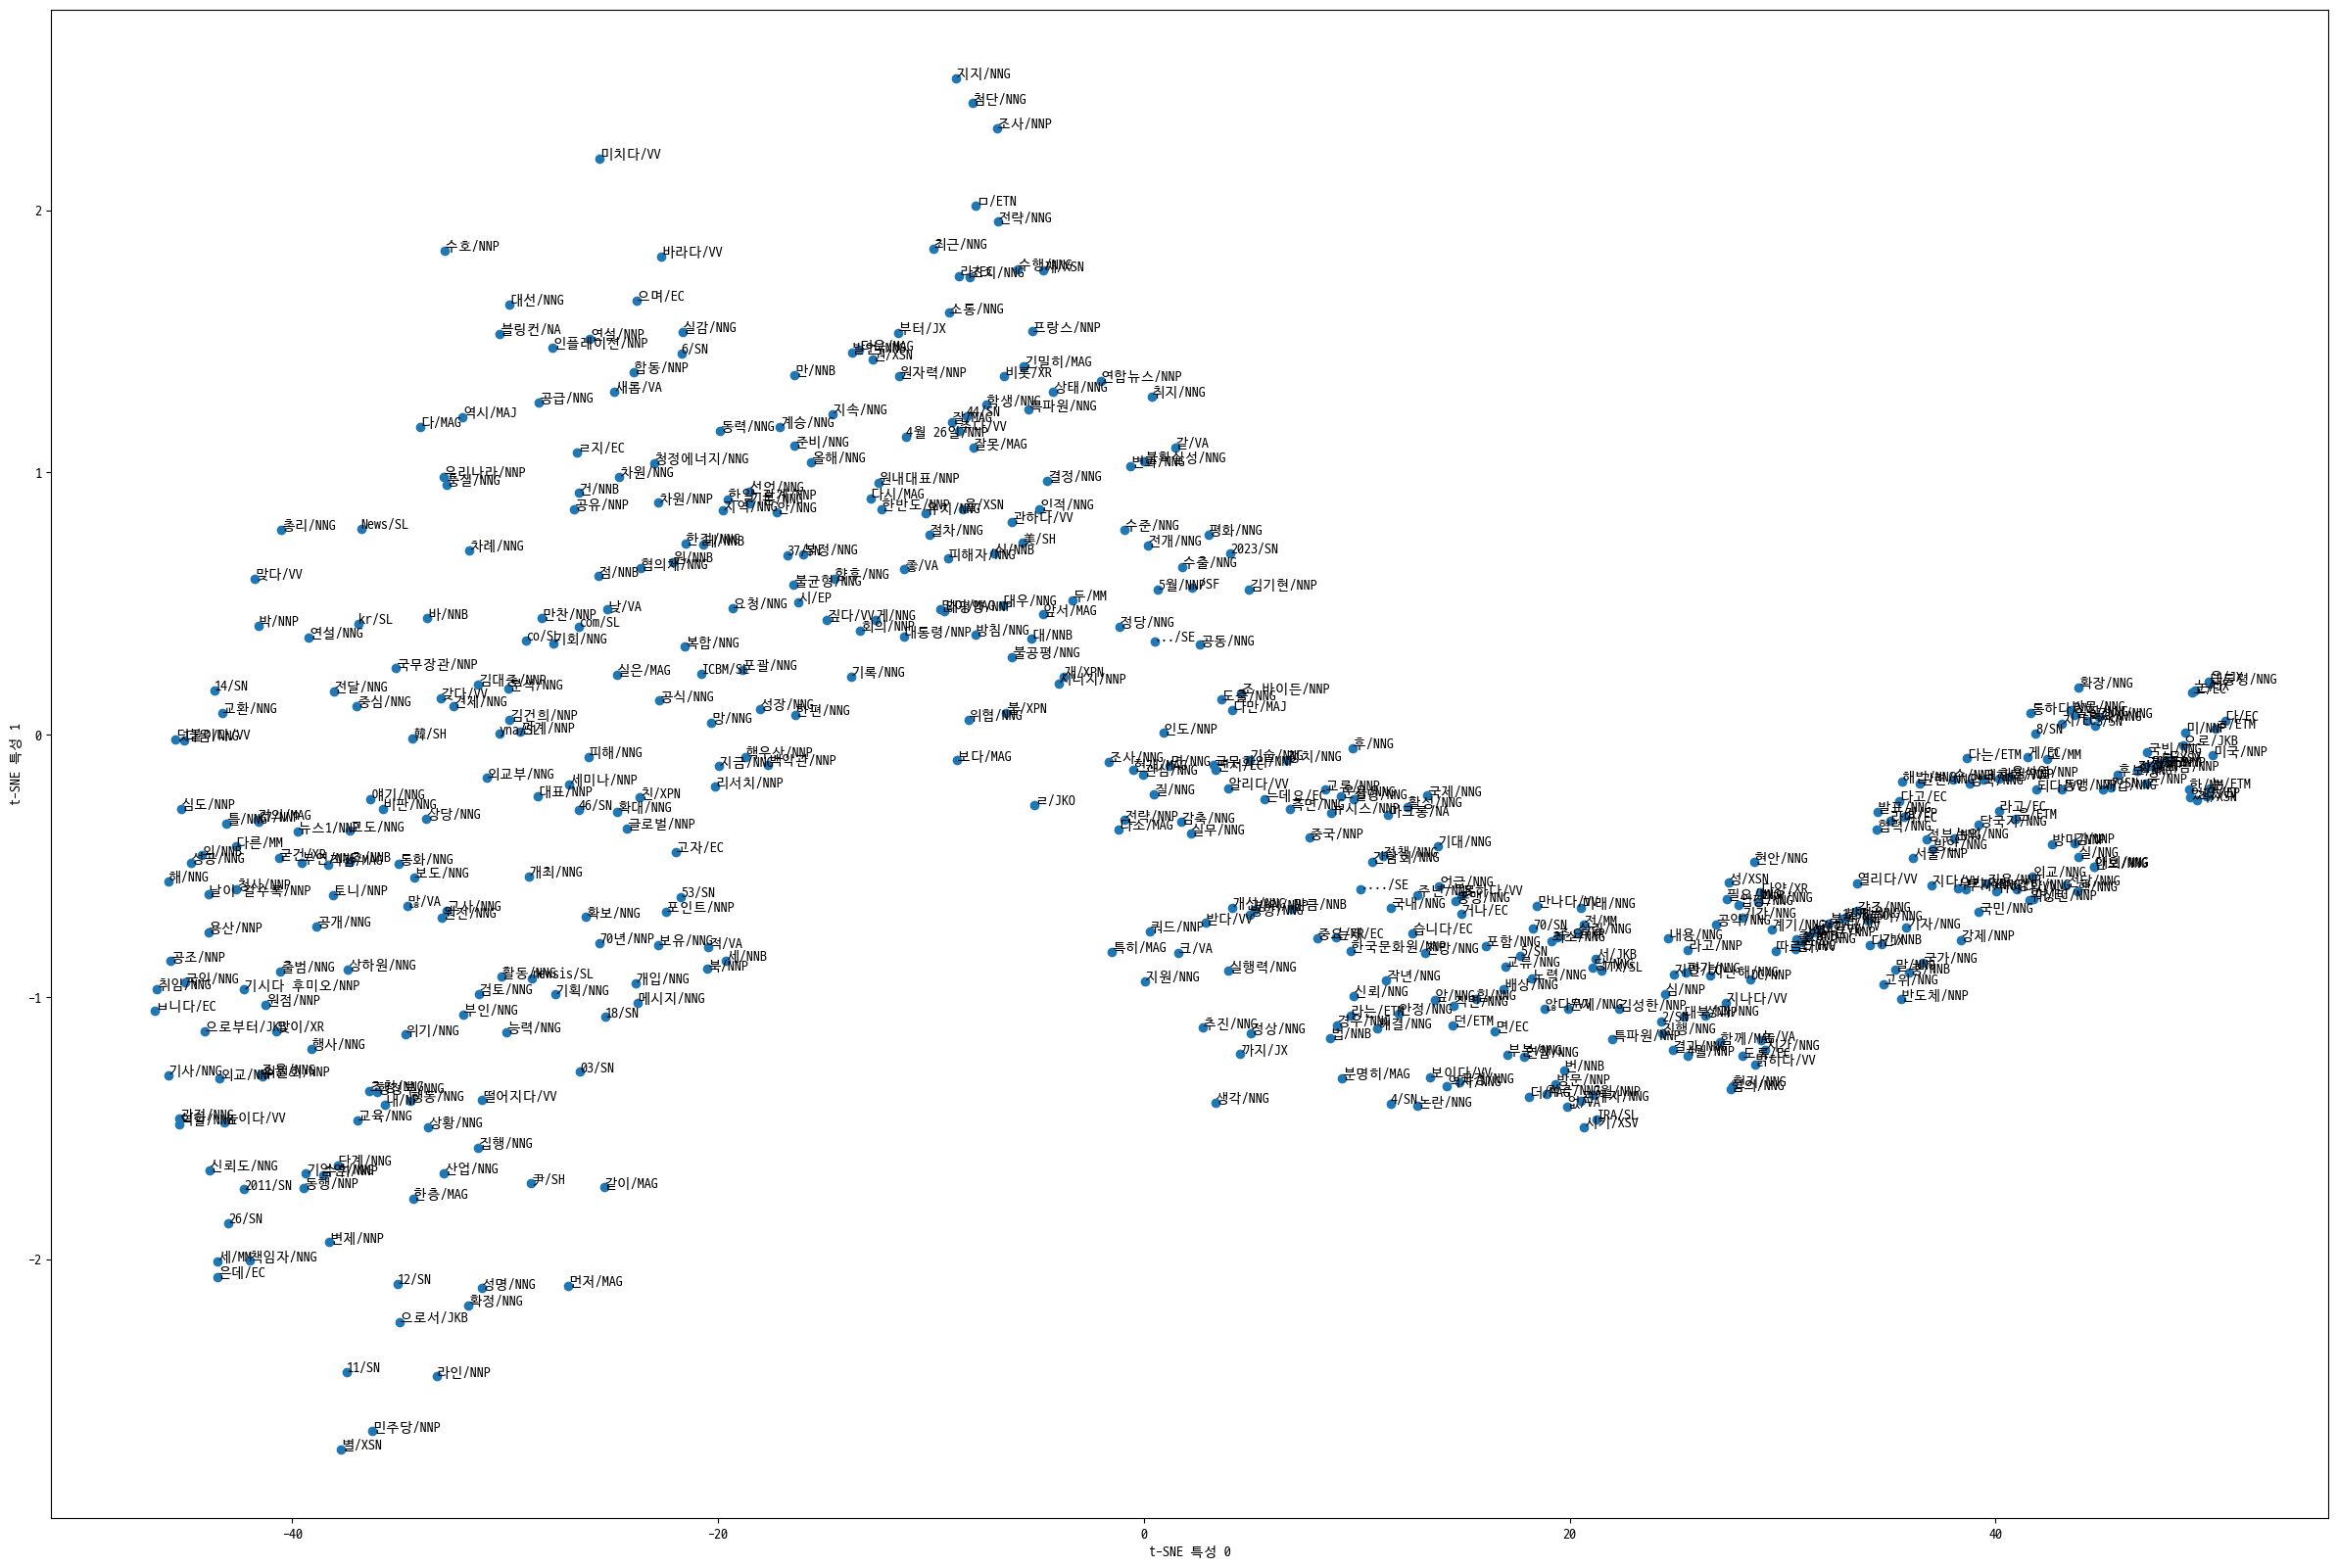

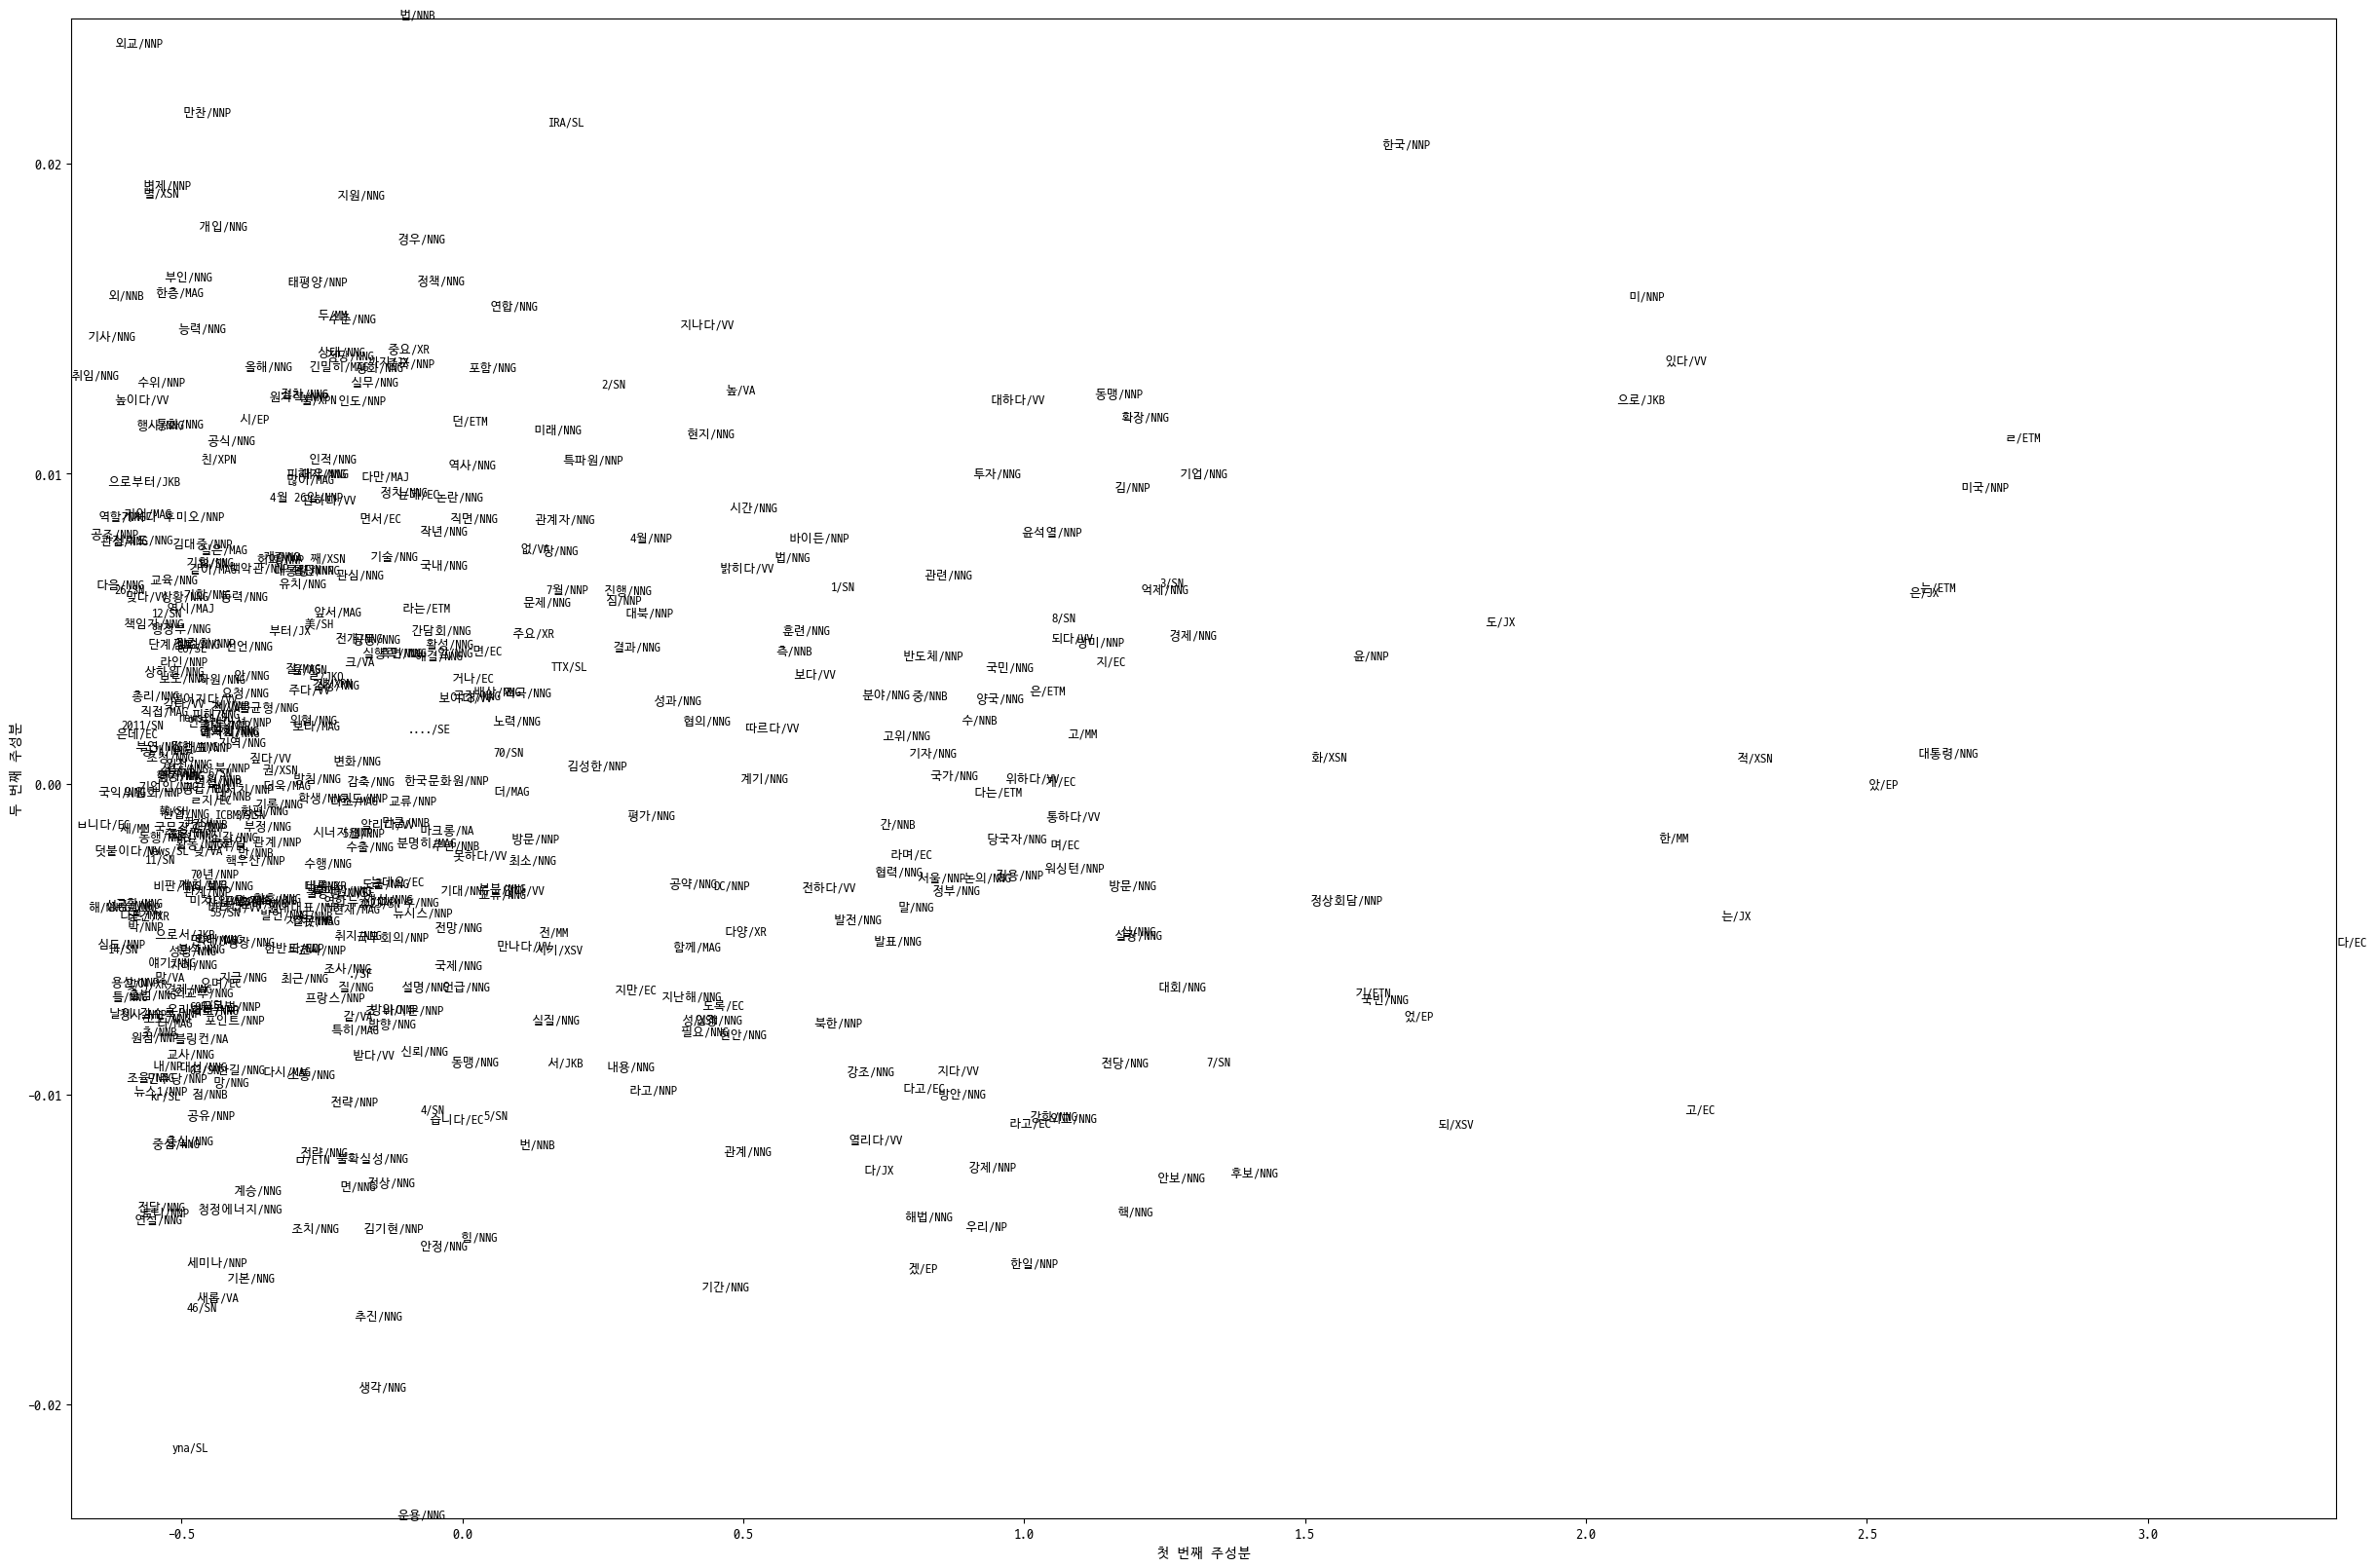

In [22]:
#visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import KeyedVectors

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family='D2Coding')

def show_tsne():
    tsne = TSNE(n_components=2)
    X = tsne.fit_transform(X_show)

    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])
    fig = plt.figure()
    fig.set_size_inches(30, 20)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=10)

    plt.xlabel("t-SNE 특성 0")
    plt.ylabel("t-SNE 특성 1")
    plt.show()


def show_pca():
    # PCA 모델을 생성합니다
    pca = PCA(n_components=2)
    pca.fit(X_show)
    # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다
    x_pca = pca.transform(X_show)

    plt.figure(figsize=(30, 20))
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max())
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max())
    for i in range(len(X_show)):
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("첫 번째 주성분")
    plt.ylabel("두 번째 주성분")
    plt.show()


vocab = list(model.wv.index_to_key)
X = model.wv[vocab]

# sz개의 단어에 대해서만 시각화
sz = 500
X_show = X[:sz,:]
vocab_show = vocab[:sz]

show_tsne()
show_pca()

In [27]:
# 문서의 vector 값 계산
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in model.wv.key_to_index:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model.wv[word]
                else:
                    doc2vec = doc2vec + model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [28]:
document_embedded = get_document_vectors(df['token'])
print("결과",len(document_embedded))

결과 15


In [34]:
# 코사인 유사도 기반 추천
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
cosine_similarities = cosine_similarity(document_embedded, document_embedded)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (15, 15)


In [55]:
def recommendations(idx):
    books = df[['_idx','title', 'full_text']]

    # 입력된 인덱스와 내용 vector 값이 유사한 6개 추출
    sim_scores = cosine_similarities[idx]
    sim_scores = sim_scores.argsort()[::-1][0:6]

    # 가장 유사한 6개의 기사 인덱스
    book_indices = sim_scores.tolist()
    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 6개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    return recommend

In [56]:
recommendations(3)

[3, 10, 7, 1, 2, 8]


,_idx,title,full_text
0,4,"尹지지율, 2.7%p 오른 44.1%…작년 7월 이후 최고[한길리서치]","부정평가는 53.8%…국민의힘 42.3%, 민주당 27.8%\n\n\n\n국무회의 ..."
1,11,"尹지지율, 44.1%…작년 7월 이후 최고치[한길리서치]",부정평가 53.8%…지난해 7월 이후 가장 낮아[이데일리 송주오 기자] 윤석열 대통...
2,8,"김성한 ""尹방미 때 핵억제 실행력 강화 모색…韓기업 불이익 최소화""(종합)","""美, 전략자산 전개·연합훈련로 美방위공약 국민 실감 계기되길 기대""""美와 尹 국빈..."
3,2,"""尹, 방미 계기 대북억제 강화 모색…美 최고 예우""(종합2보)","기사내용 요약""美, 방미 고대…한미동맹 70주년 발전 구체화""韓대통령 7번째 美 국..."
4,3,"'한일 미래협력' 예고했던 尹 ""강제징용 해법은 공약 실천""","국무회의서 ""대선 때 징용 직접 언급 안했지만, 교류 활성화 입장 밝혀와""獨-佛 적..."
5,9,"김 여사, 미 국빈방문 '내조외교'…""마크롱 여사 일정 참고""","기사내용 요약佛마크롱 국빈방문 때 영부인 '교육'에 초점金, 예술·동물복지 등 관심..."


### 그렇다면, 유저의 활동 기록에 따른 뉴스 기사 추천을 어떻게 해야 할까?
- 카테고리 별로, 한번 나눠서 다시 거기서 유사한 놈들을 추천할까?
- 아니면, 그냥 개별 뉴스별로?
- 아니면 전체 doc의 평균값을 가져와서 나만의 vec값을 만들어서 유사한 놈들을 줄까?